# **Stage 1**
***Describe Data***

A brief description of the data, where you sourced it, headers of the data. Summary statistics, charts etc...


For this project the two datasets with different sources were used:
the main dataset - from kaggle. This dataset contains 4 columns:
- title
- text
- url
- authors
- timestamp
- tags

The second dataset from retrived using the news external api and contains the next columns:
- title
- description
- source
- category

In [ ]:
import time
import requests
import pandas as pd

API_KEY = '5c51becba406403db537eacafb7fc40f'
url = 'https://newsapi.org/v2/top-headlines'

categories = [
    "business", "entertainment", "general", "health",
    "science", "sports", "technology", "politics",
    "music", "gaming"
]
data = []
index = 9
category = categories[index]

#getting data from top-headlines endpoint 
url = f"{url}?category={category}&language=en&pageSize=100&apiKey={API_KEY}"
response = requests.get(url)
if response.status_code == 200:
    articles = response.json().get("articles", [])[:150]
        
    for article in articles:
        if article["title"] and article["content"]:
            data.append({
                    "title": article["title"],
                    "description": article["description"],
                    "source": article["source"]["name"],
                    "category": category 
            })
    
print(f"Fetched {len(articles)} articles from {category}. Total: {len(data)}, index: {index}")
time.sleep(1)  

df = pd.DataFrame(data)
df.to_csv('news_with_labels.csv', index=False, header=False, mode='a')

The kaggle dataset columns:  Index(['title', 'text', 'url', 'authors', 'timestamp', 'tags'], dtype='object')
The news dataset columns: Index(['title', 'description', 'source', 'category'], dtype='object')

Kaggle dataset characters count description
 count    192368.000000
mean       5097.748134
std        5206.093120
min          10.000000
25%        1952.000000
50%        3837.000000
75%        6591.000000
max      100000.000000
Name: row_length, dtype: float64

News dataset characters count description with title and description columns
 count    365.000000
mean     227.717808
std       64.849359
min       91.000000
25%      182.000000
50%      218.000000
75%      267.000000
max      407.000000
Name: row_length, dtype: float64


Kaggle dataset tags count:  78638
News dataset tags count:  10


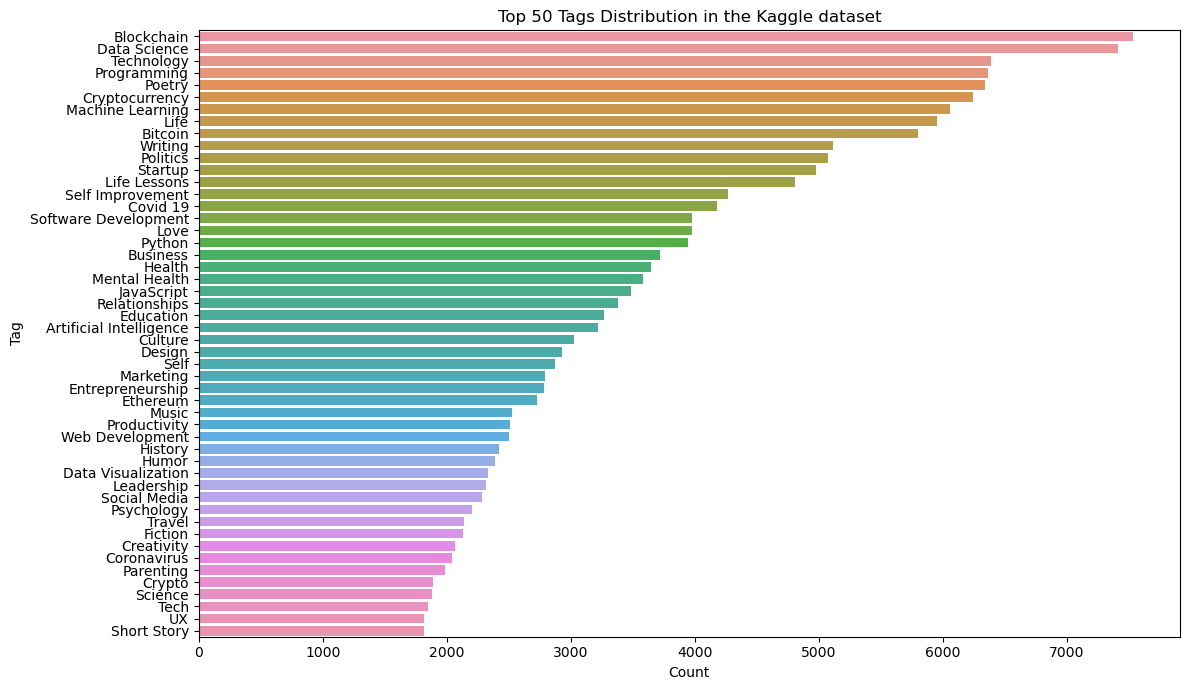

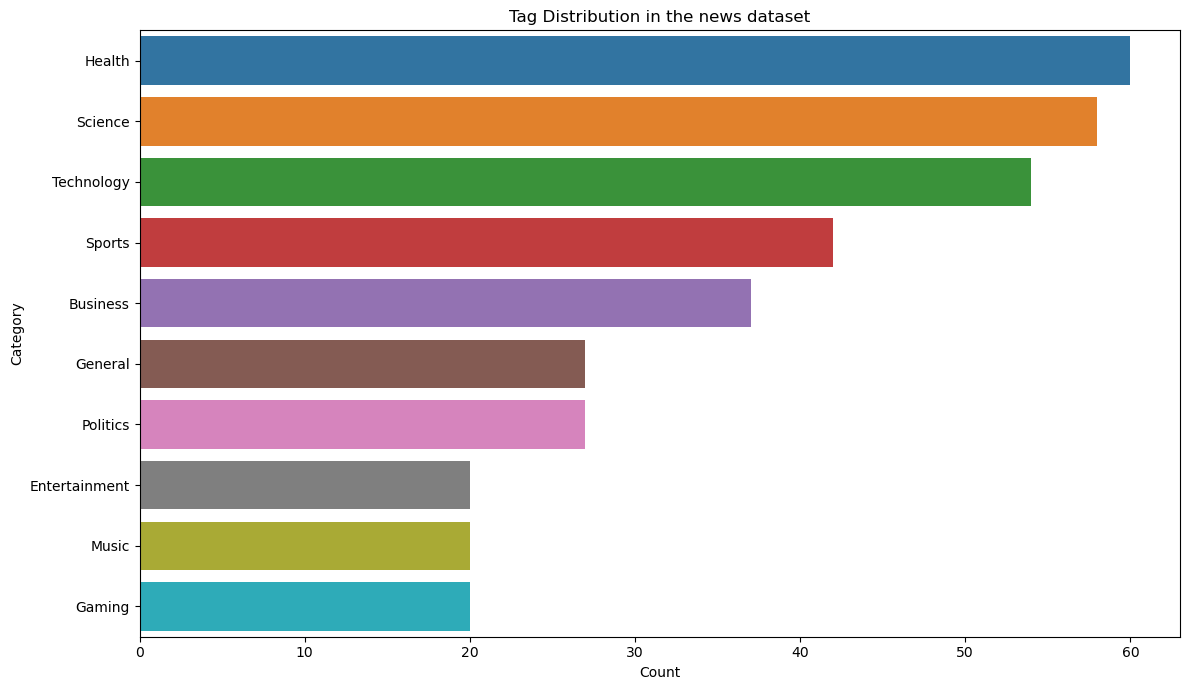

In [27]:
import pandas as pd
import ast
from collections import Counter
import seaborn as sns
import matplotlib.pyplot as plt

#dataset columns
kaggle_data = pd.read_csv("medium_articles.csv")
kaggle_data['tags'] = kaggle_data['tags'].apply(ast.literal_eval)
print("The kaggle dataset columns: ", kaggle_data.columns)
news_data=pd.read_csv("news_with_labels.csv")
news_data['category'] = news_data['category'].apply(lambda x: [x.capitalize()])
print("The news dataset columns:", news_data.columns)

#calculating how many characters in each of the dataset
kaggle_data['row_length']=kaggle_data['text'].apply(lambda x: len(x))
print("\nKaggle dataset characters count description\n", kaggle_data['row_length'].describe())

news_data['content'] = news_data['title'] + ' ' + news_data['description']
news_data['row_length']=news_data['content'].apply(lambda x: len(x))
print("\nNews dataset characters count description with title and description columns\n", news_data['row_length'].describe())


all_kaggle_tags = [tag for sublist in kaggle_data['tags'] for tag in sublist]
kaggle_tag_counts = Counter(all_kaggle_tags)
print("\n\nKaggle dataset tags count: ", len(kaggle_tag_counts))
kaggle_tag_df = pd.DataFrame(kaggle_tag_counts.items(), columns=['Tag', 'Count']).sort_values(by='Count', ascending=False)

all_news_categories = [tag for sublist in news_data['category'] for tag in sublist]
news_categories_counts = Counter(all_news_categories)
print("News dataset tags count: ", len(news_categories_counts))
news_categories_df = pd.DataFrame(news_categories_counts.items(), columns=['Category', 'Count']).sort_values(by='Count', ascending=False)

top_n = 50
top_kaggle_tags_df = kaggle_tag_df.head(top_n)

plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='Tag', data=top_kaggle_tags_df)
plt.title('Top ' + str(top_n) +' Tags Distribution in the Kaggle dataset')
plt.xlabel('Count')
plt.ylabel('Tag')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()


plt.figure(figsize=(12, 7))
sns.barplot(x='Count', y='Category', data=news_categories_df)
plt.title('Category Distribution in the news dataset')
plt.xlabel('Count')
plt.ylabel('Category')
plt.xticks()
plt.yticks()
plt.tight_layout()
plt.show()
 

# **Stage 2**

Justification for the property that the model has to predict.

The property that will be predicted - is the tags for the kaggle dataset and the category. As can be seen from the graphs above, both of them are almost the same except the categories values are stored as lower case. Also the Kaggle dataset contains much more amount of unique tags that the news dataset and the news api only 10 out of them. In the next stage the Kaggle dataset will be filtered so the tags array will always contain atleast one tag from the news dataset. The are two main reasons for this:
- The kaggle dataset already has a lot of text and in size it is huge. It would take hours or even days to train the models using all of the data available
- The purpose of this project - is to increase the model performance after joining another dataset. When the main one has already a lot of data, the performance change might be unseen due to a lot of another data. When the kaggle dataset has all tags that the news dataset has, the performance change should be much more noticable

Also because the kaggle dataset contains too many tags, some rare of them (the tags that appear less than 200 times in the dataset) will be removed. In the perfect scenario, it should not happen, but because the dataset is already going to be imbalanced, and there are too many of these rare tags, the model performance might go overfitting, ecpecially for tags that appear 10 or less times 

# **Stage 3**

Cleaning the data, linking datasets etc..



<h3>Filtering the datasets</h3>

In [53]:
import numpy as np
def remove_extra_data(data, drop_columns, drop_column_na):
    for column in drop_columns:
        data.drop(column, axis=1, inplace=True)
    data = data.dropna(subset = drop_column_na)
    return data

kaggle_data = remove_extra_data(kaggle_data, ["url","timestamp", "authors", "row_length"], ["title","text","tags"])
kaggle_data['content'] = kaggle_data['title'] + ' ' + kaggle_data['text']
kaggle_data = remove_extra_data(kaggle_data, ["title","text"], [])

news_data.columns
news_data['tags'] = news_data['category']
news_data = remove_extra_data(news_data, ["title","description", "source", "row_length", "category"], ["content","tags"])

#filtering the kaggle dataset to have atleast one tag for the news api dataset
target_tags = ['Health', 'Business', 'Entertainment', 'Science', 'Technology', 'Sports', 'Politics', 'Music', 'General', 'Gaming']
kaggle_data = kaggle_data[kaggle_data['tags'].apply(lambda tag_list: any(tag in target_tags for tag in tag_list))]


kaggle_tags = [tag for sublist in kaggle_data['tags'] for tag in sublist]
kaggle_tag_counts = Counter(kaggle_tags)
tag_df = pd.DataFrame(kaggle_tag_counts.items(), columns=['tag', 'count']).sort_values(by='count', ascending=True)
common_tags = tag_df[tag_df['count'] > 200]['tag'].to_numpy()
common_tags = np.append(common_tags, "General")
kaggle_data['tags'] = kaggle_data['tags'].apply(lambda tags: [tag for tag in tags if tag in common_tags])
kaggle_data = kaggle_data[kaggle_data['tags'].apply(len) > 0].reset_index(drop=True)

updated_tags = [tag for sublist in kaggle_data['tags'] for tag in sublist]
updated_tags_count = Counter(updated_tags)
updated_tags_df = pd.DataFrame(updated_tags_count.items(), columns=['tag', 'count']).sort_values(by='count', ascending=True)
print("The updated tags count: \n", updated_tags_count)

# As can be seen from the output, after the dataset was succsessfully fitered from tags that 
# are not in the news category dataset, most of top appearing tags in the Kaggle dataset matches the
# news categories except for general that firstly was filtered out as it appears less than 35 times 
# but it was decided to keep it as it is also an important tag for models fitting and evaluation


<h3>Data cleaning</h3>

In [74]:
import nltk
import re
def remove_punc(row):
    pattern = r"[^A-Za-z0-9']"
    return ''.join([symbol.replace("’","'") for symbol in row if symbol == ' ' or not re.fullmatch(pattern, symbol)]).lower()

def split(row):
    return ["number" if re.search(r'\d', word) else word for word in row.split(' ') if word.strip()]

def remove_stopwords(row):
    stop_words = nltk.corpus.stopwords.words('english')
    return [word for word in row if word not in stop_words]
def stem_text(row):
    ps = nltk.stem.SnowballStemmer(language='english') 
    return ' '.join([ps.stem(word) for word in row])

def lemmatize_text(row):
    lm = nltk.WordNetLemmatizer() 
    return ' '.join([lm.lemmatize(word) for word in row])

# kaggle_data['cleaned'] = kaggle_data['content'].apply(lambda x: remove_punc(x))
# kaggle_data['cleaned'] = kaggle_data['cleaned'].apply(lambda x: split(x))
# kaggle_data['cleaned'] = kaggle_data['cleaned'].apply(lambda x: remove_stopwords(x))
kaggle_data['cleaned'] = kaggle_data['cleaned'].apply(lambda x: ' '.join(x))
print("Kaggle dataset after removing punctuation and stop words:\n: ",kaggle_data['cleaned'][:5])

kaggle_data['cleaned'] = kaggle_data['cleaned'].apply(lambda x: stem_text(x.split(' ')))
kaggle_data['cleaned'] = kaggle_data['cleaned'].apply(lambda x: lemmatize_text(x.split(' ')))
print("\n\nKaggle dataset after stemming and lemmatizing:\n: ",kaggle_data['cleaned'][:5])

Kaggle dataset after removing punctuation and stop words:  0    mental note vol number photo josh riemer unspl...
1    brain coronavirus brain coronavirusa guide cur...
2    mind nose mind nosehow smell training change b...
3    number purposes dreams passionate synergy scie...
4    surviving rod head youve heard havent phineas ...
Name: cleaned, dtype: object


Kaggle dataset after stemming and lemmatizing:  0    mental note vol number photo josh riemer unspl...
1    brain coronavirus brain coronavirusa guid curi...
2    mind nose mind nosehow smell train chang brain...
3    number purpos dream passion synergi scienc tec...
4    surviv rod head youv heard havent phinea gage ...
Name: cleaned, dtype: object


In [75]:
news_data['cleaned'] = news_data['content'].apply(lambda x: remove_punc(x))
news_data['cleaned'] = news_data['cleaned'].apply(lambda x: split(x))
news_data['cleaned'] = news_data['cleaned'].apply(lambda x: remove_stopwords(x))
news_data['cleaned'] = news_data['cleaned'].apply(lambda x: ' '.join(x))
print("News dataset after removing punctuation and stop words:\n: ",news_data['cleaned'][:5])

news_data['cleaned'] = news_data['cleaned'].apply(lambda x: stem_text(x.split(' ')))
news_data['cleaned'] = news_data['cleaned'].apply(lambda x: lemmatize_text(x.split(' ')))
print("\n\nNews dataset after stemming and lemmatizing:\n: ",news_data['cleaned'][:5])

News dataset after removing punctuation and stop words
:  0    private companies added number jobs march expe...
1    ufc signs wideranging sponsorship deal meta br...
2    boeing ceo faces senate hearing plane maker's ...
3    wall street trading desks warn sp number sello...
4    airlines warned heathrow power supply days shu...
Name: cleaned, dtype: object


News dataset after stemming and lemmatizing
:  0    privat compani ad number job march expect adp ...
1    ufc sign widerang sponsorship deal meta bring ...
2    boe ceo face senat hear plane maker recoveri c...
3    wall street trade desk warn sp number selloff ...
4    airlin warn heathrow power suppli day shutdown...
Name: cleaned, dtype: object


<h3>Data preprocessing for SGDClassifier</h3>

In [63]:
from sklearn.preprocessing import MultiLabelBinarizer
from sentence_transformers import SentenceTransformer

bert_model = SentenceTransformer('all-MiniLM-L6-v2')
mlb = MultiLabelBinarizer()

y_kaggle = mlb.fit_transform(kaggle_data['tags']) 
X_kaggle = bert_model.encode(kaggle_data['content'].fillna('').astype(str).tolist(), show_progress_bar=True)

combined_data = pd.concat([kaggle_data, news_data], ignore_index=True)
combined_data = combined_data.sample(frac=1, random_state=42).reset_index(drop=True)

y_combined = mlb.fit_transform(combined_data['tags']) 
X_combined = bert_model.encode(combined_data['content'].fillna('').astype(str).tolist(), show_progress_bar=True)

<h3>Data preprocessing for Naive Bayes</h3>

In [82]:
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.feature_extraction.text import CountVectorizer

count_vectorizer = CountVectorizer()
mlb = MultiLabelBinarizer()

y_kaggle_nb = mlb.fit_transform(kaggle_data['tags']) 
X_kaggle_nb = count_vectorizer.fit_transform(kaggle_data['cleaned'])

combined_data_nb = pd.concat([kaggle_data, news_data], ignore_index=True)
combined_data_nb = combined_data_nb.sample(frac=1, random_state=42).reset_index(drop=True)

y_combined_nb = mlb.fit_transform(combined_data_nb['tags']) 
X_combined_nb = count_vectorizer.fit_transform(combined_data_nb['cleaned'])

# **Stage 4**
Choose and train Estimator.

In [56]:
def display_results(y_true_full, y_pred_full):
    print("Accuracy:", accuracy_score(y_true_full, y_pred_full))
    print("F1 score (micro):", f1_score(y_true_full, y_pred_full, average='micro'))
    print("Precision (micro):", precision_score(y_true_full, y_pred_full, average='micro'))
    print("Recall (micro):", recall_score(y_true_full, y_pred_full, average='micro'))

    y_true_flat = y_true_full.ravel()
    y_pred_flat = y_pred_full.ravel()
    cm_total = confusion_matrix(y_true_flat, y_pred_flat)
    cm_labels = ["Negative", "Positive"]
    plt.figure(figsize=(4.5, 3.5))
    sns.heatmap(cm_total, annot=True, fmt='d', cmap='Purples',
                xticklabels=cm_labels, yticklabels=cm_labels)
    plt.title("Overall Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.tight_layout()
    plt.show()

<h3>Training the model using SGDClassifier and the main dataset</h3>

In [69]:
from sklearn.multioutput import MultiOutputClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import classification_report, confusion_matrix
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, confusion_matrix
from sklearn.linear_model import SGDClassifier
from iterstrat.ml_stratifiers import MultilabelStratifiedKFold
from sklearn.model_selection import KFold

kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []

for train_idx, val_idx in kf.split(X_kaggle, y_kaggle):
    X_train, X_val = X_kaggle[train_idx], X_kaggle[val_idx]
    y_train, y_val = y_kaggle[train_idx], y_kaggle[val_idx]

    model = MultiOutputClassifier(SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    all_preds.append(y_pred)
    all_true.append(y_val)

y_true_full_kaggle = np.vstack(all_true)
y_pred_full_kaggle = np.vstack(all_preds)

<h3>Training the model using SGDClassifier and the combined dataset</h3>

In [70]:
kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []

for train_idx, val_idx in kf.split(X_combined, y_combined):
    X_train, X_val = X_combined[train_idx], X_combined[val_idx]
    y_train, y_val = y_combined[train_idx], y_combined[val_idx]

    model = MultiOutputClassifier(SGDClassifier(loss='log_loss', alpha=0.0001, max_iter=1000))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    all_preds.append(y_pred)
    all_true.append(y_val)

y_true_full_combined = np.vstack(all_true)
y_pred_full_combined = np.vstack(all_preds)

<h3>Training the model using Naive Bayes algorithm and the Kaggle dataset</h3>

In [88]:
from sklearn.naive_bayes import MultinomialNB
kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []

for train_idx, val_idx in kf.split(X_kaggle_nb, y_kaggle_nb):
    X_train, X_val = X_kaggle_nb[train_idx], X_kaggle_nb[val_idx]
    y_train, y_val = y_kaggle_nb[train_idx], y_kaggle_nb[val_idx]

    model = MultiOutputClassifier(MultinomialNB(alpha=0.0001))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    all_preds.append(y_pred)
    all_true.append(y_val)

y_true_full_nv = np.vstack(all_true)
y_pred_full_nv = np.vstack(all_preds)

<h3>Training the model using Naive Bayes and the combined dataset</h3>

In [89]:
kf = MultilabelStratifiedKFold(n_splits=5, shuffle=True, random_state=42)

all_preds = []
all_true = []

for train_idx, val_idx in kf.split(X_combined_nb, y_combined_nb):
    X_train, X_val = X_combined_nb[train_idx], X_combined_nb[val_idx]
    y_train, y_val = y_combined_nb[train_idx], y_combined_nb[val_idx]

    model = MultiOutputClassifier(MultinomialNB(alpha=0.0001))
    model.fit(X_train, y_train)
    y_pred = model.predict(X_val)

    all_preds.append(y_pred)
    all_true.append(y_val)

y_true_full_combined_nv = np.vstack(all_true)
y_pred_full_combined_nv = np.vstack(all_preds)

# **Stage 5**
Model evaluation

Accuracy: 0.23898431665421957
F1 score (micro): 0.5156227445113709
Precision (micro): 0.8079786140242649
Recall (micro): 0.3786231884057971


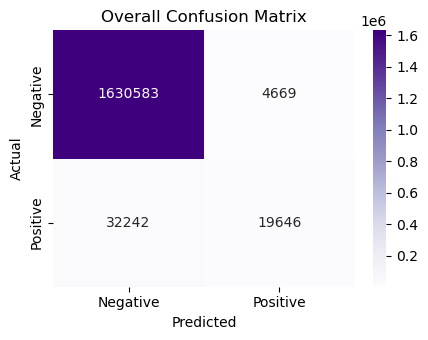

Accuracy: 0.24097764335635755
F1 score (micro): 0.5179848671021147
Precision (micro): 0.7989785332375708
Recall (micro): 0.3832124471322221


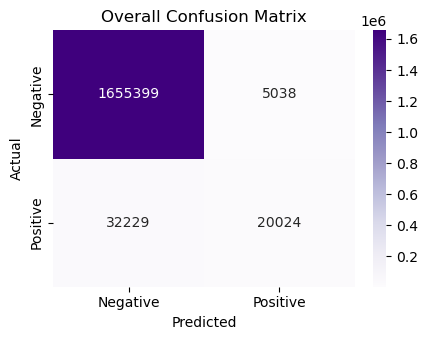

In [71]:
display_results(y_true_full_kaggle, y_pred_full_kaggle)
display_results(y_true_full_combined, y_pred_full_combined)

<h3> Naive Bayes Model evaluation</h3>

Accuracy: 0.12575719857273254
F1 score (micro): 0.4323756836612812
Precision (micro): 0.32084678397492117
Recall (micro): 0.6627543940795559


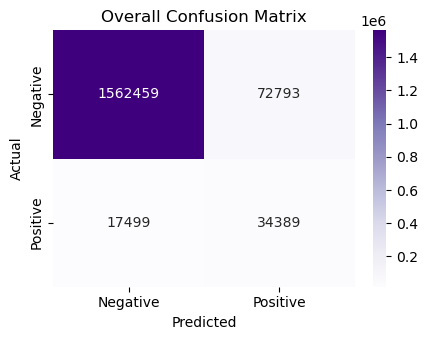

Accuracy: 0.12739608452200923
F1 score (micro): 0.43134679376516805
Precision (micro): 0.32038690614459736
Recall (micro): 0.6598855568101353


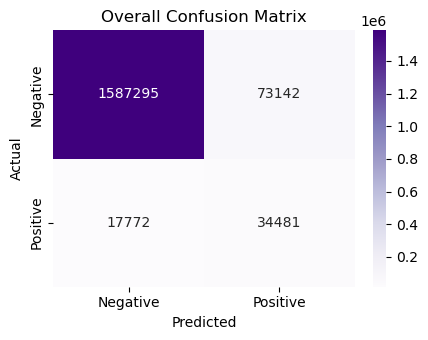

In [93]:
display_results(y_true_full_nv, y_pred_full_nv)
display_results(y_true_full_combined_nv, y_pred_full_combined_nv)

# **Stage 6**
***Present results and Conclusions***

